In [ ]:
# !pip install datasets evaluate transformers
# !pip install rouge_score
# !pip install py7zr

# Chapter 6 Text Summarization (part 2)

### Evaluating PEGASUS on the CNN/DailyMail Dataset

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from datasets import load_dataset

dataset = load_dataset("cnn_dailymail", "3.0.0")

summaries = {}

print(f"Features of the dataset: {dataset['train'].column_names}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Features of the dataset: ['article', 'highlights', 'id']


In [ ]:
[len(dataset[split]) for split in dataset.keys()]

[287113, 13368, 11490]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

In [ ]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Load rouge metric

In [ ]:
from evaluate import load

rouge_metric = load("rouge")

rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]


Summarization baseline

In [ ]:
def three_sentence_summary(example):
    return "/n".join(sent_tokenize(example)[:3])

Let's first evaluate the performance of the baseline

In [ ]:
def evaluate_summary_baseline(dataset, metric,
                              column_text='article',
                              column_summary='highlights'):
    summaries = [three_sentence_summary(example) for example in dataset[column_text]]
    metric.add_batch(predictions=summaries, references=dataset[column_summary])
    scores = metric.compute()
    return scores
# returns a dictionary where key=rouge_names elements and value=numeric value of metric

Now we apply the function to a subset of the data.

In [ ]:
test_sampled = dataset["test"].shuffle(seed=42).select(range(1000))

score = evaluate_summary_baseline(test_sampled, metric=rouge_metric)

In [ ]:
pd.DataFrame.from_dict(score, orient="index", columns=["baseline"]).T

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.380479,0.165239,0.23992,0.31527


In [ ]:
print(type(score))

print(score)

<class 'dict'>
{'rouge1': 0.3804791286327395, 'rouge2': 0.16523893404087409, 'rougeL': 0.23992026956311713, 'rougeLsum': 0.3152695274165285}


In [ ]:
test_sampled

Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 1000
})

Now let's implement the same evaluation function for evaluating the PEGASUS model

In [ ]:
from tqdm import tqdm
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

def chunks(list_of_elements, batch_size):
    """Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]



def evaluate_summary(dataset, metric, model, tokenizer,
                    batch_size=16,
                    column_text="article",
                    column_summary="highlights"):

    article_batches = list(chunks(dataset[column_text], batch_size))
    summary_batches = list(chunks(dataset[column_summary], batch_size))

    for article_batch, summary_batch in tqdm(
        zip(article_batches, summary_batches), total=len(article_batches)):

        inputs = tokenizer(article_batch, max_length=1024,
                           truncation=True, padding="max_length", return_tensors="pt")

        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                                   attention_mask=inputs["attention_mask"].to(device),
                                   length_penalty=0.8, num_beams=2, max_length=128)

        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                              clean_up_tokenization_spaces=True)
                             for s in summaries]

        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
        metric.add_batch(predictions=decoded_summaries, references=summary_batch)

    score = metric.compute()
    return score

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
score_pegasus = evaluate_summary(test_sampled, rouge_metric, model, tokenizer)

pd.DataFrame.from_dict(score_pegasus, orient="index", columns=["pegasus"]).T

100%|██████████| 63/63 [08:55<00:00,  8.50s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.438609,0.214278,0.311668,0.376472


In [ ]:
score_pegasus

{'rouge1': 0.43860887093191664,
 'rouge2': 0.21427797536463344,
 'rougeL': 0.3116684723226049,
 'rougeLsum': 0.3764717179628094}

Below are some stuff to help understand better the generator

In [ ]:
for i in range(0, 64, 16):
  print(f"{i} - {i+16}")

0 - 16
16 - 32
32 - 48
48 - 64


In [ ]:
chunks(dataset['test'][:64]["id"], 16)

<generator object chunks at 0x7bec47afc890>

In [ ]:
piece_of_data = dataset['test'][:64]["id"]

print("len of dataset: ",len(piece_of_data))
print("len of dataset chunk: ", len(list(chunks(piece_of_data, 16))))
list(chunks(piece_of_data, 16))

len of dataset:  64
len of dataset chunk:  4


[['f001ec5c4704938247d27a44948eebb37ae98d01',
  '230c522854991d053fe98a718b1defa077a8efef',
  '4495ba8f3a340d97a9df1476f8a35502bcce1f69',
  'a38e72fed88684ec8d60dd5856282e999dc8c0ca',
  'c27cf1b136cc270023de959e7ab24638021bc43f',
  '1b2cc634e2bfc6f2595260e7ed9b42f77ecbb0ce',
  'e2706dce6cf26bc61b082438188fdb6e130d9e40',
  '0d3c8c276d079c4c225f034c69aa024cdab7869d',
  '6222f33c2c79b80be437335eeb3f488509e92cf5',
  '2bd8ada1de6a7b02f59430cc82045eb8d29cf033',
  'ee17dfb574feca82ccac5689595e47483bd23f12',
  '384175be1c8d41610fbeddbd9d9cb46e716e2529',
  '203886369feea77bbc35715e6d7e518b751f57de',
  '1dd00c89d71a5611797bb34da8a6eada8f058405',
  'eeafdc8b2d8130cabda5aafe352eab1198d0b9f8',
  'dc833f8b55e381011ce23f89ea909b9a141b5a66'],
 ['c222979bd1cfbc7d3ff821e9c738e3dbd29b14f4',
  '469c6ac05092ca5997728c9dfc19f9ab6b936e40',
  '88e7dac40f3e6c159e4edc0747d0cc0f50886fbb',
  'ec4b5fef725b4cc81545689603ff84c8e19bd6dc',
  'ffff11a2f44d731cd80c86819a89b7e227581415',
  'c7caf9181c2e94a79d9102da6e11cd

---

## Evaluating PEGASUS on SAMSum

In [ ]:
from posixpath import split
from datasets import load_dataset

dataset_samsum = load_dataset("samsum")

split_list = [len(dataset_samsum[x])for x in dataset_samsum]

print(f"Features of the dataset: {dataset_samsum['train'].column_names}")
print(f"Size of the dataset: {split_list}")

print("\nDialogue:")
print(dataset_samsum["test"][1]["dialogue"])

print("\nSummary:")
print(dataset_samsum["test"][1]["summary"])

Features of the dataset: ['id', 'dialogue', 'summary']
Size of the dataset: [14732, 819, 818]

Dialogue:
Eric: MACHINE!
Rob: That's so gr8!
Eric: I know! And shows how Americans see Russian ;)
Rob: And it's really funny!
Eric: I know! I especially like the train part!
Rob: Hahaha! No one talks to the machine like that!
Eric: Is this his only stand-up?
Rob: Idk. I'll check.
Eric: Sure.
Rob: Turns out no! There are some of his stand-ups on youtube.
Eric: Gr8! I'll watch them now!
Rob: Me too!
Eric: MACHINE!
Rob: MACHINE!
Eric: TTYL?
Rob: Sure :)

Summary:
Eric and Rob are going to watch a stand-up on youtube.


Evaluating PEGASUS on SAMSum

In [ ]:
from transformers import pipeline, set_seed

set_seed(42)
model_ckpt = "google/pegasus-cnn_dailymail"

pipe = pipeline("summarization", model=model_ckpt)

pipe_out = pipe(dataset_samsum["test"][1]["dialogue"])
print("\nSummary")
print(pipe_out[0]["summary_text"].replace(" .<n>", ".\n"))

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.



Summary
Eric: Machine! Rob: Machine! Eric: Machine! Rob: TTYL?<n>Rob: Sure!<n>Eric: Gr8! I'll watch them now!<n>Rob: Me too! Eric: Machine! Rob: Machine! Eric: TTYL?


We can see that the model mostly tries to summarize by extracting the key sentences from the dialogs. This probably worked well on the CNN/DailyMail dataset, but the summaries in SAMSum are more abstract. Let's confirm by running the full ROUGE evaluation of the test set:


In [ ]:
score_sams = evaluate_summary(dataset_samsum["test"], rouge_metric, model, tokenizer,
                         column_text="dialogue", column_summary="summary", batch_size= 8)

#rouge_dict = dict((name, score[name]) for name in rouge_names)

pd.DataFrame.from_dict(score_sams, orient="index", columns=["pegasus"]).T

100%|██████████| 103/103 [06:26<00:00,  3.75s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.311744,0.09449,0.240904,0.240705


---

# Fine-Tuning PEGASUS on Samsum Dataset

Before we process the data for training, let's have a look at the length distribution of the input and outputs:

In [ ]:
d_len = [len(tokenizer(x)["input_ids"]) for x in dataset_samsum["test"]["dialogue"]]
s_len = [len(tokenizer(x)["input_ids"]) for x in dataset_samsum["test"]["summary"]]

print("Max input length:", max(d_len))
print("Max output length:", max(s_len))

Max input length: 691
Max output length: 82


In [ ]:
print(len(s_len))
print(s_len[:10])

819
[21, 15, 35, 13, 53, 65, 34, 15, 33, 27]


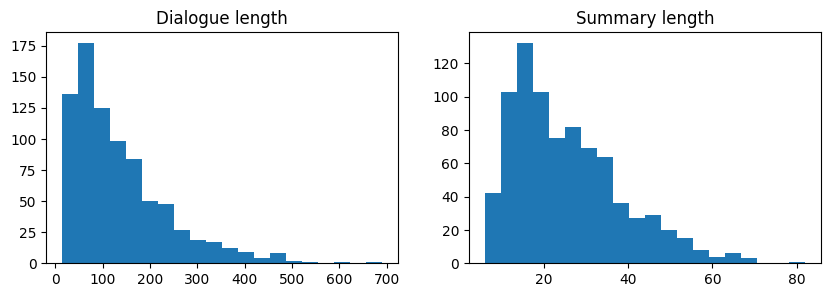

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].hist(d_len, bins=20)
axes[0].set_title("Dialogue length")
axes[1].hist(s_len, bins=20)
axes[1].set_title("Summary length")
plt.show()

First we need to tokenize the dataset. We will set the max length to 1024 and 128 for the dialogues and summaries.

In [ ]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["dialogue"], max_length=1024,
                                truncation=True)
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length=128,
                                     truncation=True)

        return {
        "input_ids": input_encodings["input_ids"],
        "attention_mask": input_encodings["attention_mask"],
        "labels": target_encodings["input_ids"]
    }

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched=True)
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4126: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [ ]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="pegasus-samsum", num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10,
    evaluation_strategy="steps", eval_steps=500, save_steps=1e6,
    push_to_hub=False,
    gradient_accumulation_steps=16
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(model=model, args=training_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"],
                  eval_dataset=dataset_samsum_pt["validation"]
                  )

In [ ]:
trainer.train()

score_finetuned = evaluate_summary(dataset_samsum["test"], rouge_metric, trainer.model,
                         tokenizer, column_text="dialogue", column_summary="summary",
                         batch_size=8)

pd.DataFrame.from_dict(score_finetuned, orient="index", columns=["pegasus"]).T

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: ERROR API key must be 40 characters long, yours was 37


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/usr/local/lib/python3.10/dist-packages/transformers/data/data_collator.py:656: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)


Step,Training Loss,Validation Loss
500,1.653300,1.487004


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 128, 'min_length': 32, 'num_beams': 8, 'length_penalty': 0.8, 'forced_eos_token_id': 1}
100%|██████████| 103/103 [05:01<00:00,  2.93s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.417885,0.191045,0.327207,0.327096


## Generating Dialog Summaries

In [ ]:
gen_kwargs = {"length_penalty": 0.8, "num_beams": 8, "max_length": 128}
sample_text = dataset_samsum["test"][10]["dialogue"]
reference = dataset_samsum["test"][10]["summary"]

pipe = pipeline("summarization", model=model, tokenizer=tokenizer)
pipe_out = pipe(sample_text, **gen_kwargs)[0]["summary_text"]

print(f"Dialogue:\n{sample_text}\n\nReference Summary:\n{reference}\n\nModel Summary:\n{pipe_out}")


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Dialogue:
Wanda: Let's make a party!
Gina: Why?
Wanda: beacuse. I want some fun!
Gina: ok, what do u need?
Wanda: 1st I need too make a list
Gina: noted and then?
Wanda: well, could u take yours father car and go do groceries with me?
Gina: don't know if he'll agree
Wanda: I know, but u can ask :)
Gina: I'll try but theres no promisess
Wanda: I know, u r the best!
Gina: When u wanna go
Wanda: Friday?
Gina: ok, I'll ask

Reference Summary:
Wanda wants to throw a party. She asks Gina to borrow her father's car and go do groceries together. They set the date for Friday. 

Model Summary:
Gina and Wanda want to make a party. Wanda will take Gina's father car and go to do groceries on Friday. Gina will ask Wanda's father if he'll agree.
